# Preprocessing

In [1]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
import tifffile as tif
import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage
import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting

In [2]:
n_channels = 2
n_cycles = 5

img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
img_size = img.shape[:2]

X = np.zeros((n_channels*n_cycles, 1, *img_size))
k = 0
for i in range(n_channels):
    for j in range(n_cycles):
        fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
        print(fn)
        img = tif.imread(fn)
        X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
        k = k+1

./data/crisprmap20210506/amp-ch1-cycle0.tiff
./data/crisprmap20210506/amp-ch1-cycle1.tiff
./data/crisprmap20210506/amp-ch1-cycle2.tiff
./data/crisprmap20210506/amp-ch1-cycle3.tiff
./data/crisprmap20210506/amp-ch1-cycle4.tiff
./data/crisprmap20210506/amp-ch2-cycle0.tiff
./data/crisprmap20210506/amp-ch2-cycle1.tiff
./data/crisprmap20210506/amp-ch2-cycle2.tiff
./data/crisprmap20210506/amp-ch2-cycle3.tiff
./data/crisprmap20210506/amp-ch2-cycle4.tiff


In [3]:
img.shape

(2048, 1792, 4)

In [4]:
X.shape

(10, 1, 2048, 1792)

In [5]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

In [6]:
# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle2.tiff')
# plt.figure(dpi=100)
# plt.imshow(img[80:100, 80:100, 1])
# plt.axis('image')
# # im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

In [7]:
up = 10
down = 1900
left = 50
right = 1650

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [8]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [9]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix
codebook = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [10]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [11]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [12]:
Xcenter.shape

(10, 1, 1890, 1600)

In [13]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [14]:
Xnorm.shape

(10, 1, 1890, 1600)

In [15]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xnorm[i, 0,])

## Distribution

In [16]:
# # create the histogram
# for i in range(Xnorm.shape[0]):
#     histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

## Thresholding

In [17]:
Xnorm.shape

(10, 1, 1890, 1600)

In [18]:
Xnorm[0, 0,].shape

(1890, 1600)

In [19]:
# upper = 0.9
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
# Xthresh = Xnorm.copy()
# for i in range(Xthresh.shape[0]):
#     single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
#     single[single > upper] = upper
#     Xthresh[i, 0] = single

In [20]:
residual = 0.125  # tested through the spot method and the cell method should be less sensitive 
Xthresh = Xnorm.copy()
Xthresh[Xthresh < residual] = 0

In [21]:
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

In [22]:
# # Before and after (partial region)
# # with bardensr.plotting.AnimAcross() as a:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=250)
#     plt.subplot(1, 2, 1)
# #     a('before')
#     plt.imshow(Xnorm[i, 0, 200:500, 200:500])
#     plt.subplot(1, 2, 2)
# #     a('after')
#     plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Peak calling and counting (inside membrane masks)

**Check by overlay to see if there are enough spots called.**

In [23]:
# Read in the membrane segmentation
hf = h5py.File("./data/Ben_MembraneSegmentation_NuclearGFP_2021-06-22.hdf5", "r")
print(hf.keys())
masks_mem = hf["Cell Seg Mask"]

<KeysViewHDF5 ['Average GFP Masks', 'Cell Seg Mask', 'Max Projection', 'Nuc Seg Mask', 'Summed GFP Masks']>


In [24]:
# plt.figure(dpi=250)
# plt.imshow(masks_mem)
# plt.axis('image')

In [25]:
# Find the number of membrane segmentation masks
np.unique(masks_mem)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [26]:
# # Check starting from which number the masks are truly membrane segmentation (instead of the background)
# plt.figure(dpi=300)
# for i in range(0, 5):
#     plt.figure()
#     plt.imshow(np.array(masks_mem)==i)

In [27]:
#     xindex = test.loc[i, 'm2'] + left
#     yindex = test.loc[i, 'm1'] + up

In [28]:
# pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))

In [29]:
# cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

for k in range(Xthresh.shape[0]):  # for the kth image
    # Get local maximum values of desired neighborhood (size of the amplicons)
    max_fil = ndimage.maximum_filter(Xthresh[k,], size=(1, 2, 2))

    # Threshold the image to find locations of interest
    # assuming 6 standard deviations above the mean of the image
    peak_thresh = max_fil.mean() + max_fil.std() * 6

    # find areas greater than peak_thresh
    labels, num_labels = ndimage.label(max_fil > peak_thresh)

    # Get the positions of the maxima
    coords = ndimage.measurements.center_of_mass(Xthresh[k,], 
                                                 labels=labels, 
                                                 index=np.arange(1, num_labels + 1))

    # # Get the maximum value in the labels
    # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
    # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

    for _, m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
        if mem_id>0: # 0 is background
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [30]:
# labels

In [31]:
# num_labels

In [32]:
coords[:10]

[(0.0, 6.543602130081081, 861.0),
 (0.0, 8.0, 108.59272456891979),
 (0.0, 9.481436771695659, 903.0),
 (0.0, 11.254144676468409, 729.667745198682),
 (0.0, 14.440051349491345, 1046.6361900533907),
 (0.0, 14.434706722909056, 1560.5603333633226),
 (0.0, 30.0, 542.0),
 (0.0, 30.435710348342994, 854.9999999999999),
 (0.0, 34.46947260290432, 990.7079067808304),
 (0.0, 34.362508995111035, 1529.6088846841628)]

In [33]:
int(np.round(801.5228444869555))

802

In [34]:
len(coords)

299

In [35]:
cell_table

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  3.,  0.,  0.],
       ...,
       [ 2.,  8.,  1., ...,  2.,  1.,  0.],
       [ 0.,  1.,  9., ..., 10.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.]])

In [52]:
cell_table.shape

(660, 10)

# Nearest Neighbor/Correlation

In [36]:
# Calculate the correlation
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

In [37]:
cell_corr[200:205,]

array([[1.38873008, 0.        , 0.10286889, 0.05143445, 0.20573779,
        0.77151671, 0.8743856 , 0.72008226, 0.20573779, 0.10286889],
       [0.64326749, 0.        , 0.05360562, 0.        , 0.91129561,
        0.16081687, 0.2144225 , 0.53605624, 0.10721125, 0.85768998],
       [0.04944682, 0.09889363, 0.09889363, 0.        , 0.9889363 ,
        0.14834045, 1.03838312, 0.        , 0.9889363 , 0.09889363],
       [1.38873004, 0.        , 0.15430334, 0.        , 0.        ,
        0.77151669, 0.61721335, 0.77151669, 0.        , 0.15430334],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [38]:
cell_corr.shape

(660, 10)

In [39]:
# cell_norm + 1e-6

In [40]:
# (cell_table.dot(codebook.T) / np.reshape(cell_norm, (-1,1))).shape

In [41]:
# cell_norm

In [42]:
# np.reshape(cell_norm, (-1,1))

In [65]:
# Assign cells to barcodes according to the max correlation
cell_id = pd.DataFrame(np.argmax(cell_corr, axis=1), columns=['barcode'])
cell_id

,barcode
0,0
1,0
2,4
3,0
4,0
...,...
655,0
656,9
657,5
658,4


In [44]:
# cell_id.loc[200:210]

In [45]:
# cell_id.to_csv('./result/crisprmap20210506_layer1out0123_cell_id_thresh6std.csv', index=False)

In [70]:
heapq.nlargest(2, cell_corr[116,])

[1.183215756619957, 1.183215756619957]

In [67]:
cell_id['max'] = np.max(cell_corr, axis=1)
# cell_id['second_max'] = [heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index]
cell_id['quality'] = cell_id['max'] - [heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index]
cell_id = cell_id.sort_values(by=['quality'], ascending=False)
cell_id

,barcode,max,quality
291,1,1.327772,1.327772
406,1,1.212678,1.212678
359,1,1.306515,1.200582
98,1,1.301583,1.193117
156,1,1.309153,1.166336
...,...,...,...
580,2,1.010363,0.000000
116,4,1.183216,0.000000
578,4,0.999999,0.000000
21,4,0.999999,0.000000


<AxesSubplot:xlabel='quality', ylabel='Count'>

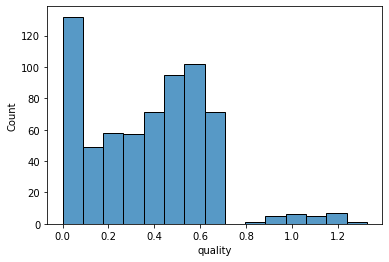

In [68]:
import seaborn as sns
sns.histplot(data=cell_id, x="quality")

In [ ]:
# Possibly plot which cells have high quality scores
plt.figure(dpi=300)
for i in range(300, 305):
    plt.figure()
    plt.imshow(np.array(masks_mem)==i)

In [60]:
# sns.histplot(data=cell_id, x="max")

In [59]:
set(cell_id['max'])

{1.4142134909445272}

In [61]:
np.max(cell_corr)

1.4142134909445272

In [62]:
cell_corr.shape

(660, 10)

<!-- list1 = [10, 20, 4, 45, 99]
 
# new_list is a set of list1
new_list = set(list1)
 
# removing the largest element from temp list
new_list.remove(max(new_list))
 
# elements in original list are not changed
# print(list1)
 
print(max(new_list)) -->